# Car Object Detection with YOLOv8
In this notebok, we will explore the field of object detection by implementing a car detection algorithm using YOLOv8. Our dataset is sourced from the Kaggle dataset titled "Car Object Detection," available at https://www.kaggle.com/datasets/sshikamaru/car-object-detection


## Dataset Overview
The "Car Object Detection" dataset provides a collection of 1176 images annotated with bounding boxes around car objects. The annotations are on a CSV file containing information about the bounding box coordinates and other relevant details.

In order to implement this project, it will be neccessary to:

Load and preprocess the dataset, ensuring it is in a format suitable for YOLOv8, Set up the YOLOv8 model for car detection.

Customize the configuration based on the dataset characteristics.

Fine-tune the YOLOv8 model on the car detection dataset.

Monitor training progress and evaluate the model's performance.

Analyze the results, visualize detection outputs, and assess the model's accuracy.

## Setup and Dependencies

> The os module provides a way of interacting with the operating system. In this context, it will be used for handling file paths and directory operations.

> Shutil will be uded to move some files during data preparation.

> Torch is an machine learning framework. It provides tools for building and training neural networks.

> Pandas is a powerful data manipulation library. It's often used for loading and manipulating structured data, such as CSV files.

> Numpy is a fundamental library for numerical operations in Python and is widely used in machine learning and data science.

> Matplotlib is a popular data visualization library. The pyplot module provides a convenient interface for creating plots and charts. The patches module within matplotlib is used for drawing shapes on plots. It will be used for visualizing bounding boxes.

> ultralytics is a library that includes the YOLO (You Only Look Once) object detection model. It likely provides convenient tools for training, evaluating, and using YOLO models.

> YAML is a human-readable data serialization format. It's often used for configuration files. In this context, it will be used to configure the YOLO model and training parameters.

> sklearn will be used to split train dataset into train and validation.

> Drive is part of the Google Colab library and is used to mount Google Drive into the Colab environment. This allows you to access and store files in your Google Drive.


In [1]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 4.1 MB/s eta 0:00:00


In [15]:
import os
import shutil
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from ultralytics import YOLO
import yaml

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, we should define the main paths for our files

In [3]:
PATH = '/content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data'
train_images = f'{PATH}/train/images'
train_bboxes = pd.read_csv(f'{PATH}/train_solution_bounding_boxes (1).csv')

test_images = f'{PATH}/test/images'

The annotations csv file comes in the format (xmin, ymin), (xmax, ymax), which is very popular among annotations and compatible with YOLO.

In [4]:
train_bboxes.head(8)

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
5,vid_4_10100.jpg,447.568741,160.625804,582.083936,232.517696
6,vid_4_10120.jpg,168.755427,180.677284,304.738061,246.700450
7,vid_4_10140.jpg,0.000000,188.991313,85.111433,249.145753


Here are some samples of pictures on the test dataset. Bouding boxes will be drawn in the next cell.

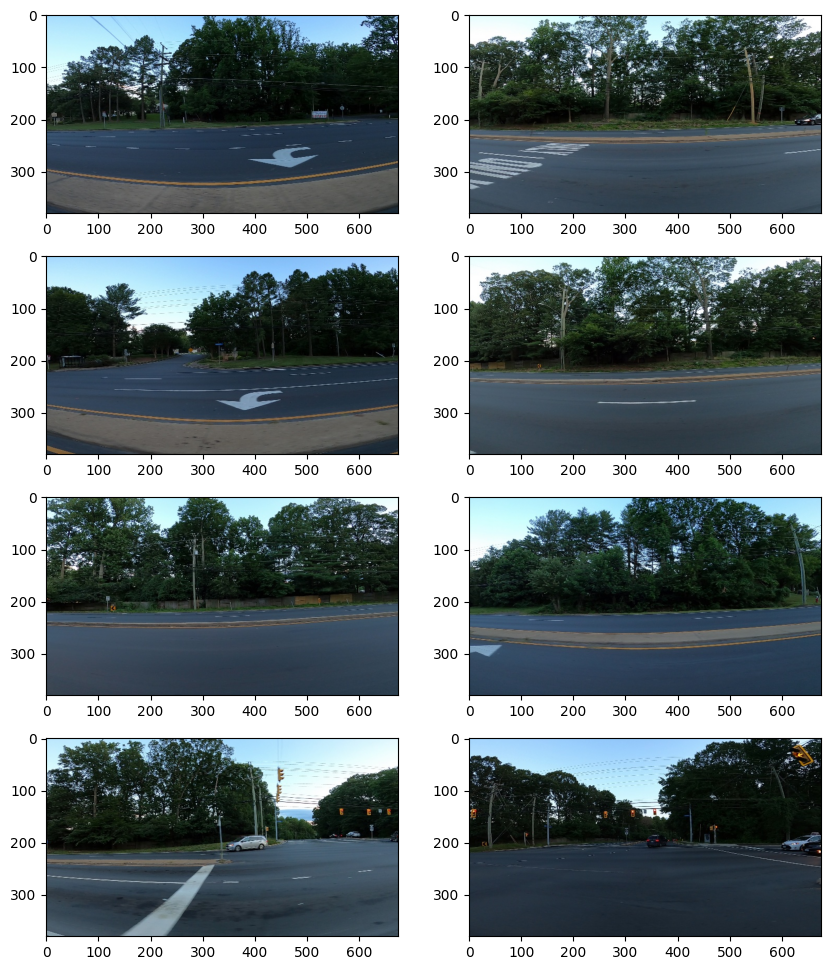

In [5]:
fig, ax = plt.subplots(4, 2, figsize=(10, 12))
for i, image in enumerate(os.listdir(train_images)[:8]):
    img = plt.imread(f'{train_images}/{image}')
    ax[i//2, i%2].imshow(img)
plt.show()

Each image may have zero or more bouding boxes, depending on the number of cars in sight. We are using matplotlib.patches to draw bouding boxes, so it is necessary to temporarily convert the annotations into (xmin, ymin), (width, height) foramt.

>width = xmax - xmin

>height = ymax - ymin

Here are the bounding boxes of the previously seen images:

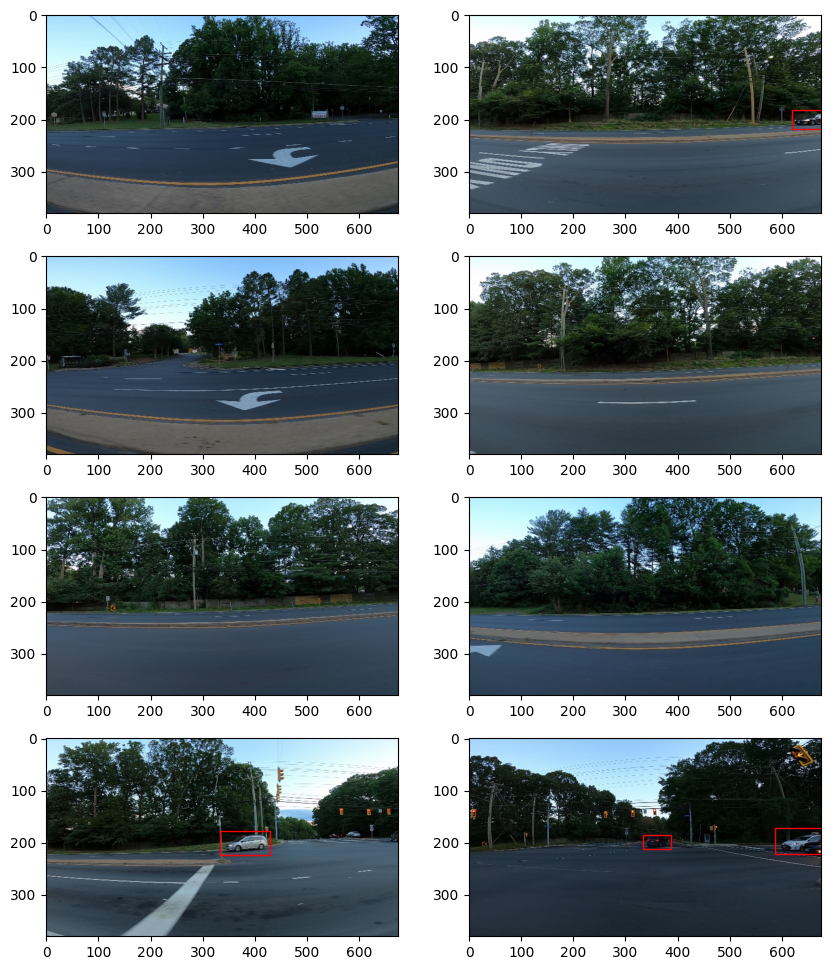

In [6]:
fig, ax = plt.subplots(4, 2, figsize=(10, 12))
for i, image in enumerate(os.listdir(train_images)[:8]):
    img = plt.imread(f'{train_images}/{image}')
    ax[i//2, i%2].imshow(img)

    bboxes = train_bboxes[train_bboxes['image'] == image][['xmin', 'ymin', 'xmax', 'ymax']]
    if len(bboxes) != 0:
        for index, row in bboxes.iterrows():
            rect = patches.Rectangle((float(row['xmin']), float(row['ymin'])), (float(row['xmax'])-float(row['xmin'])),
                                     (float(row['ymax'])-float(row['ymin'])), linewidth=1, edgecolor='r', facecolor='none')
            ax[i//2, i%2].add_patch(rect)

plt.show()

Here we encounter our first major problem. Even though the annotations are in (xmin, ymin), (xmax, ymax), the whole file and dataset organization are not compatible with the YOLOv8 training format. Files are expected to be organized like:

> train
> > images
> > > img1.jpg

> > > img2.jpg

> > > ...

> > labels
> > > img1.txt

> > > img2.txt

> > > ...

> valid
> > ...

> test
> > ...

The following code gets each image and creates this kind of file structure: Note that the folders "images" and "labels" were manually created. Also, all the coordinates have to be normalized.

In [8]:
output_dir = f'{PATH}/train/labels'

for image_path, group in train_bboxes.groupby('image'):
    txt_file_path = os.path.join(output_dir, os.path.splitext(os.path.basename(image_path))[0] + ".txt")

    with open(txt_file_path, 'w') as txt_file:
        for index, row in group.iterrows():
            class_id = 0
            x_center = (row['xmin'] + row['xmax']) / (2 * 676)
            y_center = (row['ymin'] + row['ymax']) / (2 *380)
            width = (row['xmax'] - row['xmin']) / 676
            height = (row['ymax'] - row['ymin']) / 380

            # YOLO format: class x_center y_center width height
            line = f"{class_id} {x_center} {y_center} {width} {height}\n"
            txt_file.write(line)

for image in os.listdir(train_images):
    txt_file_path = os.path.join(output_dir, os.path.splitext(os.path.basename(image))[0] + ".txt")
    with open(txt_file_path, 'a') as txt_file:
        pass

The train dataset has 1001 samples.

In [11]:
len(os.listdir(f'{PATH}/train/labels')), len(os.listdir(f'{PATH}/train/images'))

(1001, 1001)

There was no validation dataset in the original files. So, we will take 25% of the training images to belog to validation, since YOLO requires a labeled validation dataset.

In [16]:
all_train_images = os.listdir(train_images)

train_im, val_im = train_test_split(all_train_images, test_size=0.25, random_state=9)
print(len(train_im), len(val_im))

750 251


In [17]:
val_lab = [os.path.splitext(os.path.basename(i))[0] + ".txt" for i in val_im]

val_lab[:3], val_im[:3]

(['vid_4_10440.txt', 'vid_4_26180.txt', 'vid_4_13100.txt'],
 ['vid_4_10440.jpg', 'vid_4_26180.jpg', 'vid_4_13100.jpg'])

In [18]:
source_folder_images = f'{PATH}/train/images'
source_folder_labels = f'{PATH}/train/labels'
destination_folder_images = f'{PATH}/valid/images'
destination_folder_labels = f'{PATH}/valid/labels'


for file_name in val_im:
    source_path = os.path.join(source_folder_images, file_name)
    destination_path = os.path.join(destination_folder_images, file_name)
    shutil.move(source_path, destination_path)

for file_name in val_lab:
    source_path = os.path.join(source_folder_labels, file_name)
    destination_path = os.path.join(destination_folder_labels, file_name)
    shutil.move(source_path, destination_path)

Now we can create our YAML file, it will provide the needed configurations for our YOLO model.

In [20]:
config = {
    'train': '/content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/train',
    'val': '/content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/valid',
    'nc': 1,
    'names': ['car']
}

yaml_str = yaml.dump(config, default_flow_style=False)
with open(f'{PATH}/my_config.yaml', 'w') as yaml_file:
    yaml_file.write(yaml_str)

YOLOv8 can be seamlessly integrated and used directly within a Python environment, thanks to the library and dependencies imported in the initial setup. In this project, we opt for the utilization of a pre-trained YOLOv8 model. Pre-trained models are trained on large-scale datasets and can effectively generalize across a wide range of object categories, making them a powerful starting point for various applications.

In [35]:
model = YOLO("yolov8n.pt")

model.train(data=f'{PATH}/my_config.yaml', epochs=10, batch=8)  # train the model
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/my_config.yaml, epochs=10, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

train: Scanning /content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/train/labels.cache... 750 images, 467 backgrounds, 0 corrupt: 100%|██████████| 750/750 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/valid/labels.cache... 251 images, 179 backgrounds, 0 corrupt: 100%|██████████| 251/251 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.33G      1.421      6.751      1.208          2        640: 100%|██████████| 94/94 [00:25<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.17it/s]

                   all        251        103      0.987      0.766      0.942      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.23G      1.481      5.272      1.271          2        640: 100%|██████████| 94/94 [00:25<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.05it/s]

                   all        251        103      0.908      0.777      0.903      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.21G       1.39      4.006      1.268          4        640: 100%|██████████| 94/94 [00:26<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]


                   all        251        103      0.867      0.922      0.952      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.21G      1.458      3.114      1.286          1        640: 100%|██████████| 94/94 [00:22<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]

                   all        251        103      0.922      0.913      0.957      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.21G      1.352      2.306      1.216          0        640: 100%|██████████| 94/94 [00:24<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


                   all        251        103      0.943      0.932      0.984      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.21G      1.343      1.806      1.189          0        640: 100%|██████████| 94/94 [00:22<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]

                   all        251        103      0.954      0.951      0.982      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.21G       1.36      1.603      1.219          2        640: 100%|██████████| 94/94 [00:22<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


                   all        251        103      0.942      0.971      0.985      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.21G      1.263      1.394      1.163         14        640: 100%|██████████| 94/94 [00:25<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.94it/s]


                   all        251        103       0.98      0.959      0.993      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.21G      1.267      1.298       1.15          1        640: 100%|██████████| 94/94 [00:22<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]

                   all        251        103      0.974      0.942      0.985      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.21G      1.202      1.097      1.139          6        640: 100%|██████████| 94/94 [00:23<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.09it/s]

                   all        251        103      0.982      0.961      0.993      0.643



10 epochs completed in 0.081 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


                   all        251        103      0.982      0.961      0.993      0.644
Speed: 0.5ms preprocess, 6.0ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/detect/train6
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/valid/labels.cache... 251 images, 179 backgrounds, 0 corrupt: 100%|██████████| 251/251 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


                   all        251        103      0.982      0.961      0.993      0.643
Speed: 0.5ms preprocess, 6.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train62


Let's make some predictions for the test dataset. Unfortunately there are no predefined labels available, but we can check some images to see how our model performed.

In [36]:
results = model.predict(f"{PATH}/test/images/", save=True)


image 1/175 /content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/test/images/vid_5_25100.jpg: 384x640 (no detections), 15.7ms
image 2/175 /content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/test/images/vid_5_25120.jpg: 384x640 (no detections), 35.8ms
image 3/175 /content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/test/images/vid_5_25140.jpg: 384x640 (no detections), 14.6ms
image 4/175 /content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/test/images/vid_5_25160.jpg: 384x640 (no detections), 9.8ms
image 5/175 /content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/test/images/vid_5_25180.jpg: 384x640 (no detections), 14.0ms
image 6/175 /content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Car Object Detection/data/test/images/vid_5_25200.jpg: 384x640 (no detections), 10.3ms
image 7/175 /con

The model's performance in eight of the test images is shown below.

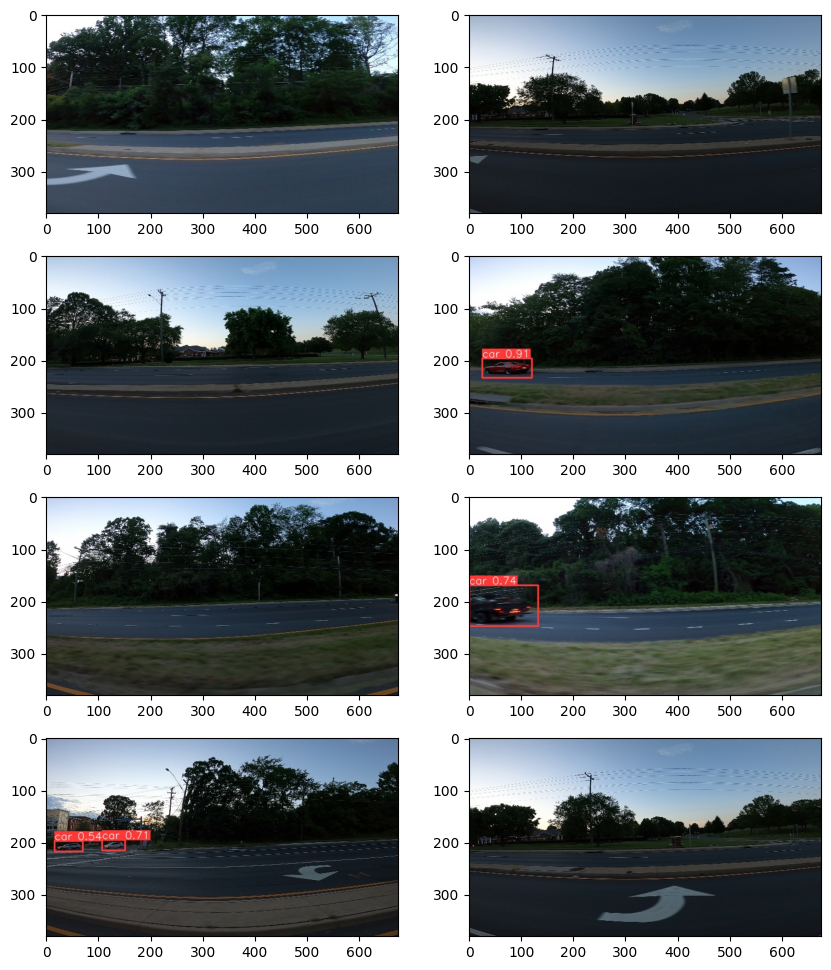

In [37]:
result_path = '/content/runs/detect/train63'
fig, ax = plt.subplots(4, 2, figsize=(10, 12))
for i, image in enumerate(os.listdir(result_path)[:8]):
    img = plt.imread(f'{result_path}/{image}')
    ax[i//2, i%2].imshow(img)
plt.show()

In [38]:
# path = model.export(format="onnx")

## Conclusion

In the course of the YOLOv8 car detection project, we successfully implemented a YOLO based object detection algorithm. The journey presented its challenges, and notably, the most demanding aspect proved to be organizing the dataset into a structure compatible with YOLO's requirements.

The meticulous process of preparing the data involved transforming annotations, normalizing coordinates, and creating a structure that adhered to the YOLO format. This step was critical for the model to effectively learn and generalize to detect cars in diverse scenarios.

In conclusion, the YOLOv8 car detection project stands as a testament to the fusion of cutting-edge algorithms with thoughtful data preparation, resulting in a powerful system capable of accurately detecting cars in real-world situations.

## References
Here are some links that helped us through our overall implementation. It is also worth mentioning some chats with ChatGPT and random StackOverflow formums.

https://pjreddie.com/darknet/yolo/

https://github.com/ultralytics/ultralytics

https://docs.netspresso.ai/docs/ms-step1-prepare-dataset